In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from datetime import datetime
import time
import joblib
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import loguniform

In [2]:
# Display all dataframe columns
pd.set_option('display.max_columns', None)

In [3]:
from sklearn.metrics import mean_squared_error

def rmse_precent(y_true, y_pred):
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # RMSE% rispetto alla media
    return (rmse / np.mean(y_true)) * 100

In [4]:
df = pd.read_csv("meleto_per_analisi.csv")
display(df.head(3))

,Treatment,target,botton_score,max,min,range,mean,std,median,non_zero_per_row
0,UTC,0.75,0.0430,16.3,13.1,3.2,15.0750,1.3769,15.45,4
1,UTC,0.33,0.1130,17.3,12.2,5.1,14.7333,2.5502,14.70,3
2,UTC,0.25,0.0406,15.6,12.7,2.9,14.2000,1.3342,14.25,4


In [5]:
print(df.apply(lambda col: col.unique()))

Treatment                                      [UTC, Brevis, BA, ACC]
target              [0.75, 0.33, 0.25, 0.5, 0.67, 1.0, 0.0, 0.4, 0...
botton_score        [0.043, 0.113, 0.0406, 0.0986, 0.0447, 0.1202,...
max                 [16.3, 17.3, 15.6, 16.4, 15.7, 15.8, 15.1, 13....
min                 [13.1, 12.2, 12.7, 9.0, 11.9, 11.0, 9.5, 7.5, ...
range               [3.2, 5.1, 2.9, 7.4, 3.8, 4.8, 7.8, 7.6, 4.9, ...
mean                [15.075, 14.7333, 14.2, 13.5, 13.3667, 13.6333...
std                 [1.3769, 2.5502, 1.3342, 3.3882, 2.0429, 2.433...
median              [15.45, 14.7, 14.25, 14.3, 12.5, 14.1, 16.7, 9...
non_zero_per_row                                [4, 3, 1, 5, 2, 6, 7]
dtype: object


In [6]:
# get treatment type for train_test_split stratify    
treatment = df['Treatment']

In [7]:
# one-hot encoding with Pandas
df["Treatment"] = df["Treatment"].astype(str).str.strip() # sanitize
df = pd.get_dummies(df, columns=["Treatment"])
df.head(3)

,target,botton_score,max,min,range,mean,std,median,non_zero_per_row,Treatment_ACC,Treatment_BA,Treatment_Brevis,Treatment_UTC
0,0.75,0.0430,16.3,13.1,3.2,15.0750,1.3769,15.45,4,False,False,False,True
1,0.33,0.1130,17.3,12.2,5.1,14.7333,2.5502,14.70,3,False,False,False,True
2,0.25,0.0406,15.6,12.7,2.9,14.2000,1.3342,14.25,4,False,False,False,True


In [8]:
y = df['target'] 
X = df.drop(['target'], axis=1) # drop target
display(X)

,botton_score,max,min,range,mean,std,median,non_zero_per_row,Treatment_ACC,Treatment_BA,Treatment_Brevis,Treatment_UTC
0,0.0430,16.30,13.10,3.20,15.0750,1.3769,15.45,4,False,False,False,True
1,0.1130,17.30,12.20,5.10,14.7333,2.5502,14.70,3,False,False,False,True
2,0.0406,15.60,12.70,2.90,14.2000,1.3342,14.25,4,False,False,False,True
3,0.0986,16.40,9.00,7.40,13.5000,3.3882,14.30,4,False,False,False,True
4,0.0447,15.70,11.90,3.80,13.3667,2.0429,12.50,3,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
10427,0.0288,18.81,15.19,3.62,16.2300,1.7367,15.46,4,True,False,False,False
10428,0.0334,18.79,15.75,3.04,17.2220,1.1902,17.05,5,True,False,False,False
10429,0.0669,17.25,13.66,3.59,14.8280,1.4150,14.24,5,True,False,False,False
10430,0.0437,15.24,12.46,2.78,13.6880,1.2680,13.48,5,True,False,False,False


In [9]:
# 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=treatment)

In [10]:
# Remove botton score
X_train = X_train.drop(['botton_score'], axis=1)

# remove botton score
botton_score_test = X_test['botton_score']
X_test = X_test.drop(['botton_score'], axis=1)

# display for check
display(X_train.head(3))
display(X_test.head(3))

,max,min,range,mean,std,median,non_zero_per_row,Treatment_ACC,Treatment_BA,Treatment_Brevis,Treatment_UTC
4451,18.0,16.0,2.0,17.00,1.1547,17.00,4,False,True,False,False
572,8.5,4.9,3.6,6.35,1.5330,6.00,4,False,False,True,False
3422,12.6,5.8,6.8,10.11,3.7476,11.93,3,False,False,True,False


,max,min,range,mean,std,median,non_zero_per_row,Treatment_ACC,Treatment_BA,Treatment_Brevis,Treatment_UTC
3491,11.53,7.24,4.29,9.494,1.5808,9.80,5,False,False,True,False
10119,16.48,7.06,9.42,12.222,3.9492,13.44,5,True,False,False,False
6655,10.52,9.51,1.01,10.042,0.4358,9.92,5,False,False,True,False


In [11]:
# Metrics for botton score for all sample no treatment
metrics_botton_score = {
    'Model': 'Botton score',
    'MAE': mean_absolute_error(y_test, botton_score_test), # Mean Absolute Error
    'MSE': mean_squared_error(y_test, botton_score_test), # Mean Squared Error
    'RMSE': root_mean_squared_error(y_test, botton_score_test), # Root Mean Squared Error
    'RMSE_per': rmse_precent(y_test, botton_score_test), # Root Mean Squared Error %    
    'R2': r2_score(y_test, botton_score_test), # R^2
    'Median_AE': median_absolute_error(y_test, botton_score_test) # Median Absolute Error
}

## XGB Regression for all sample and treatments as feature

In [12]:
# Define hyperparameter distribution for xgboost
param_dist = {
    'n_estimators': randint(500, 1500), # integer
    'max_depth': randint(3, 10), # integer
    'min_child_weight': randint(1, 50), # integer
    'subsample': uniform(loc=0.5, scale=0.5), # float loc=0.5 (inizio intervallo) e scale=0.5 (lunghezza intervallo), 0-5 + 0.5 = 1
    'colsample_bytree': uniform(loc=0.5, scale=0.5), # float
    'learning_rate': beta(a=2, b=1, loc=0.05, scale=0.15), # Valori tra 0.1 e 0.2 saranno più probabili di quelli vicino a 0.05.
    'gamma': loguniform(1e-2, 10),  # più densità vicino a 0.01–1, meno verso 10
    'alpha': loguniform(1e-3, 10),  # 0.001 – 10 la maggior parte delle volte i valori ottimali sono bassi (vicino a 0–1), ma conviene testare anche numeri più grandi.
    'lambda': loguniform(1e-3, 10)  # da 0.001 a 10
}

In [13]:
model = XGBRegressor(booster="gbtree", n_jobs=-1)

# Perform randomized search
xgb_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=1000,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
    # random_state=42
)

# Fit the model 
xgb_search.fit(X_train, y_train.squeeze())

# Miglior modello e predizioni
best_model = xgb_search.best_estimator_ # BEST MODEL
y_pred = best_model.predict(X_test)

# Metrics for xgb
metrics = {
    'Model': 'XGBoost',
    'MAE': mean_absolute_error(y_test, y_pred), # Mean Absolute Error
    'MSE': mean_squared_error(y_test, y_pred), # Mean Squared Error
    'RMSE': root_mean_squared_error(y_test, y_pred), # Root Mean Squared Error
    'RMSE_per': rmse_precent(y_test, y_pred), # Root Mean Squared Error %    
    'R2': r2_score(y_test, y_pred), # R^2
    'Median_AE': median_absolute_error(y_test, y_pred) # Median Absolute Error
}

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


In [14]:
# Save all
timestamp = datetime.now().strftime("%Y%m%dT%H%M") # Timestamp per i file
    
# (1) Save Best Model
joblib.dump(best_model, f"XGB_gbtree_AllSamples_best_model_{timestamp}.pkl")
    
# (2) Save Metrics
df_metrics = pd.DataFrame([metrics_botton_score, metrics])  # una riga con tutte le metriche
df_metrics.to_csv(f"XGB_gbtree_AllSamples_evaluation_metrics_{timestamp}.csv", index=False)
    
# (3) Save best hyper-parameters
best_params = xgb_search.best_params_ # get best hyper-parameters
df_params = pd.DataFrame([best_params])  # una riga con tutti gli iperparametri
df_params.to_csv(f"XGB_gbtree_AllSamples_best_params_{timestamp}.csv", index=False)
    
# (4) Save y_test e y_pred
df_pred = pd.DataFrame({'y_test': y_test.squeeze(), 'y_pred': y_pred})
df_pred.to_csv(f"XGB_gbtree_AllSamples_predictions_{timestamp}.csv", index=False)

In [15]:
print("Errors Botton score for all sample and no treatment as feature:")
print(f" - MAE: {round(metrics_botton_score['MAE'], 4)}")
print(f" - MSE: {round(metrics_botton_score['MSE'], 4)}")
print(f" - RMSE: {round(metrics_botton_score['RMSE'], 4)}")
print(f" - RMSE_per: {round(metrics_botton_score['RMSE_per'], 4)}")
print(f" - R2: {round(metrics_botton_score['R2'], 4)}")
print(f" - Median Absolute Error: {round(metrics_botton_score['Median_AE'], 4)}")

Errors Botton score for all sample and no treatment as feature:
 - MAE: 0.5023
 - MSE: 0.342
 - RMSE: 0.5848
 - RMSE_per: 89.4091
 - R2: -2.2662
 - Median Absolute Error: 0.498


In [16]:
print("Errors XGboost for all sample and no treatment as feature:")
print(f" - MAE: {round(metrics['MAE'], 4)}")
print(f" - MSE: {round(metrics['MSE'], 4)}")
print(f" - RMSE: {round(metrics['RMSE'], 4)}")
print(f" - RMSE_per: {round(metrics['RMSE_per'], 4)}")
print(f" - R2: {round(metrics['R2'], 4)}")
print(f" - Median Absolute Error: {round(metrics['Median_AE'], 4)}")

Errors XGboost for all sample and no treatment as feature:
 - MAE: 0.2224
 - MSE: 0.0756
 - RMSE: 0.275
 - RMSE_per: 42.0482
 - R2: 0.2776
 - Median Absolute Error: 0.1928


In [17]:
importance = best_model.get_booster().get_score(importance_type='gain')

# converti in DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# ordina in ordine decrescente
feat_importances = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature importance:\n", feat_importances)

feat_importances.to_csv(f"XGB_gbtree_AllSamples_FeatureImportance_{timestamp}.csv", index=False)


Feature importance:
              Feature  Importance
10     Treatment_UTC    6.120318
9   Treatment_Brevis    3.080926
7      Treatment_ACC    2.410513
1                min    2.397662
5             median    1.215633
8       Treatment_BA    1.107654
3               mean    0.964736
0                max    0.947246
2              range    0.927651
6   non_zero_per_row    0.721698
4                std    0.695356


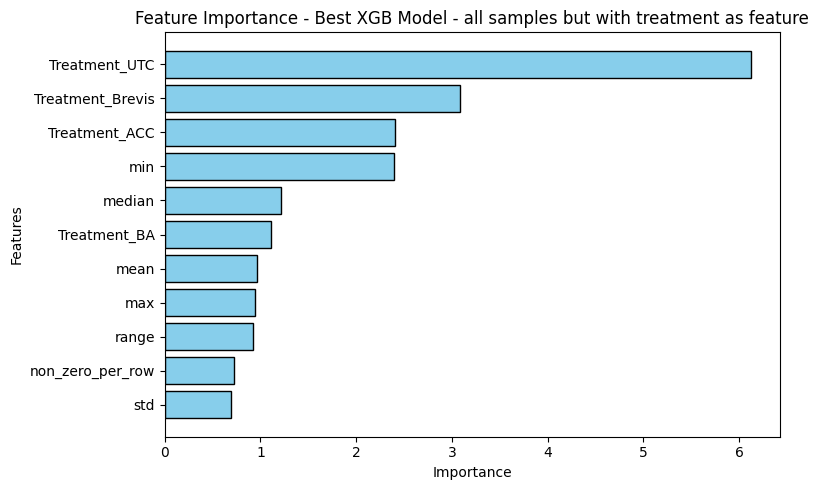

In [18]:
plt.figure(figsize=(8,5))
plt.barh(feat_importances["Feature"], feat_importances["Importance"], color="skyblue", edgecolor="black")
plt.title("Feature Importance - Best XGB Model - all samples but with treatment as feature")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Per avere la più importante in alto
plt.tight_layout()
plt.show()